## 1. Intro : Breaking RSA encryption and Order Finding

- Goal: Demonstrate how RSA encryption can be broken with a quantum computer (with Shor's algorithm) and compare it to classical methods.
- In RSA, factoring the product of two primes becomes feasible once we find the order of a co-prime number `a modulo n`. In Quantum Computing, Shor's algorithm enables this through quantum phase estimation (QPE).


# Python Imports

In [133]:
from math import gcd
import math
from fractions import Fraction
import pandas as pd
import numpy as np
import time

# Quantum Programming
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

# Plotting (for visualization)
from matplotlib import pyplot as plt

## 2. Classical Order Finding

In [134]:
# Adapted code from lecture 14 solution
def classical_order_finding(a, n):
    """
    Finds the order r such taht `a^r ≡ 1 mod n` assuming a and n are co-prime.
    If yes, proceed to calcalate until we find `a^r mod n = 1`.
    
    Returns:
    - r: the smallest integer such that a^r % n == 1
    - t: runtime in seconds
    - r: for iteration count
    
    Order size (= power) does not correlate directly with n 
    - Some large n value still yield small r
    - Below pair of numbers are picked to show 
        how classical algorithm struggles when orders (iterations) get higher
    - Normally more orders ≠ proportionally more run time
    """
    
    if gcd(a, n) != 1:
       raise ValueError("a and n must be co-prime (gcd(a, n) = 1) to define a valid order.")
    
    t0 = time.time()
    power = a
    r = 1
    MAX_ITER = 10_000_000      
    while power != 1:
        r += 1
        power = pow(power, r, n)
        if r > MAX_ITER:
            raise RuntimeError(f"Exceeded max iterations while finidng order of {a} mod {n}.")
       
    t = time.time() - t0   
    return r, t, r  # r = iteration count

for a, n in [[2, 15], [3, 1019], [4, 153488707270219], [5, 3416178076769076332873]]:
    r, t , _ = classical_order_finding(a, n)
    print(f"Total run-time to find order {r} of {a} mod {n} = {t:.3f}s")

Total run-time to find order 4 of 2 mod 15 = 0.000s
Total run-time to find order 509 of 3 mod 1019 = 0.000s
Total run-time to find order 219749 of 4 mod 153488707270219 = 0.578s
Total run-time to find order 2799187 of 5 mod 3416178076769076332873 = 10.228s


In [135]:
# Use this to see the cycle (periodicity)
def get_modular_exponentiation_sequence (a, n, max_power=10):
    powers = np.arange(0, max_power) # skip power = 0
    result = [pow(a, int(r), n) for r in powers]  
    output_df = pd.DataFrame({"sequence": result})
    output_df.index.name = "power"
    return output_df

# Example of order of 2 mod 15
df = get_modular_exponentiation_sequence(2, 15)
order = df[df['sequence'] == 1].index[1] # skip power=0
print("Classical order r =", order)

get_modular_exponentiation_sequence(2,15)

Classical order r = 4


,sequence
power,
0,1
1,2
2,4
3,8
4,1
5,2
6,4
7,8
8,1


## 3. Quantum Order Finding with Shor's Algorithm
### 3.1 Overview of Shor's Algorithm
- Step 1. Choose a random a < n such that gcd(a, n) = 1
- Step 2. Use Quantum Phase Estimation (QPE) to find the order `r`
- Step 3. Use classical post-processing (factorization) to extract factors (p,q)

### 3.2 Circuit: Modular Multiplication Gate `U`
We define a unitary operator `U |b⟩ = |a * b mod n⟩`.
This gate is used in the QPE circuit to encode the periodicity.

In [136]:
# Utility function to build U |b⟩ = |a * b mod n⟩
def modular_multiplication_gate_U(a, n, label=None): 
    dimension = 2 ** math.ceil(math.log2(n)) # Find the smallest power of 2 >= n (2**k, k qubits)
    U = np.zeros((dimension, dimension)) # initialize with 0s
    
    for b in range(n):
      ab_mod_n = (a * b) % n
      U[ab_mod_n, b] = 1
      
    # Fill rest with identity to make U unitary
    for i in range(n, dimension):
      U[i, i] = 1
      
    return UnitaryGate(U, label=label or f"U{a} mod {n}")

The order finding circuit


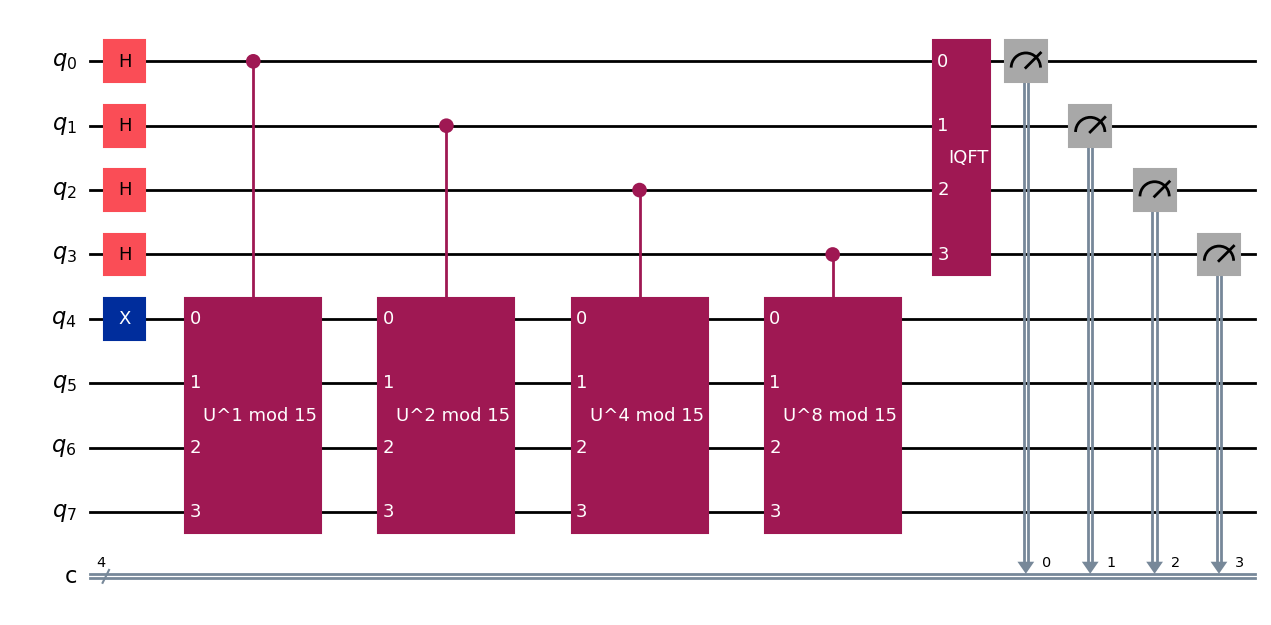

In [137]:
# Adapted code from lecture 14 excercise solution
def qpe_order_finding_circuit(a, n, t):
      # determin number of qubits needed
      counting_qubits = t
      target_qubits = math.ceil(math.log2(n)) # Enough to represent n 
      qc = QuantumCircuit(counting_qubits + target_qubits, counting_qubits)
      
      # Prepare target register in the eigenstate |1>
      qc.x(counting_qubits) # Apply X gate to the least significant bit of target
      
      # Apply Hadamards on counting qubits 
      for qubit in range(counting_qubits):
            qc.h(qubit)
      
      # Apply controlled modular multiplication gates
      for j in range(counting_qubits):
            exponent = 2**j
            mod_base = pow(a, exponent, n)
            control = j
            target = list(range(counting_qubits, counting_qubits + target_qubits))
            U = modular_multiplication_gate_U(mod_base, n, label=f"U^{exponent} mod {n}").control()
            qc.append(U, [control] + target) 
      
      # Apply inverse QFT
      qc.append(QFT(counting_qubits, do_swaps=True).inverse(), range(counting_qubits))
      
      # Measure counting register
      qc.measure(range(counting_qubits), range(counting_qubits))
      
      return qc


# Show the circuit (how the QPE works)
print("The order finding circuit")
qc = qpe_order_finding_circuit(a=2, n=15, t=4)
qc.draw('mpl')

### 3.3 Quantum Phase Estimation
We apply QPE using the `U` gate to extract the phase, which relates to `r`.

In [145]:
# Build and simulate QPE circuit using Qiskit
def quantum_order_finding(a, n, t=4 , shots=None):  
    qc = qpe_order_finding_circuit(a, n, t) 
    # Simulate the quantum order finding circuit
    if shots is None :
        shots = 200 * (2**t)
    simulator = Aer.get_backend('aer_simulator') # simulate quantum circuits on a classical computer
    qc_sim = transpile(qc, simulator)
    result = simulator.run(qc_sim, shots=shots).result()
    counts = result.get_counts()
    most_common = max(counts, key=counts.get) # Find the most frequently measured bitstring (phase)
    phase = int(most_common, 2) / 2**t # get decimal approximation of the phase
    frac = Fraction(phase).limit_denominator(n) # convert decimal phase into s/r, using continued fractions
    r = frac.denominator # extract r (= order of a modulo n)

    return {
        "shots": shots,
        "estimated_order": r,
        "phase": phase,
        "fraction": frac,
        "counts": counts,
        "circuit": qc_sim
        }

### 3.4 Results and Visualization

Result of running the circuit 3200 times: 
Most common outcome: 1100
Estimated Phase: 0.75
Fractional Estimate: 3/4 (s/r)
Extracted order r = 4


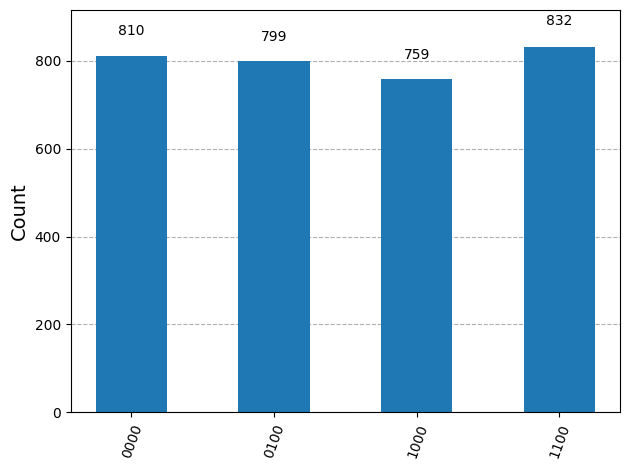

In [146]:
# Show the measurement(probability distribution of bitstrings) result
res = quantum_order_finding(a=2, n=15, t=4)
print(f"Result of running the circuit {res['shots']} times: ")
# Summary
print(f"Most common outcome: {max(res['counts'], key=res['counts'].get)}")
print(f"Estimated Phase: {res['phase']}")
print(f"Fractional Estimate: {res['fraction']} (s/r)")
print(f"Extracted order r = {res['estimated_order']}")
plot_histogram(res['counts']) 


### 3.5 Discrepancy (Limitation of QPE)

To increase accuracy I tried/did following:
  - add more counting qubits(t) from 4 to 8 
  - increased number of shots from 100 to (200 * 2^t)

---
 - Increasing counting qubits(t) can result in higher phase resolution
(Precision ≈ 1 / 2**t).
 - Increasing number of shots can give more reliable statistics.
But even with high `t` and many shots, **we can still get wrong `r`** if:

    1. The wrong peak is detected: Sometimes noise/randomness dominates
    2. The continued fraction gives a wrong `r`: we must filter out bad denomiators
    that don't satisfy `a^r mod n = 1`.
    3. `r` is odd or dosen't help factoring: Even a correct `r` may not lead to a factor (bad luck!)
    4. Modular multiplication gate `U` or circuit has bugs: Even small bugs (Wrong exponent
    or control wires) can ruin eigenvalue estimation.

In this simulation, therefore, we must verify the extimated `r` classically, and rerun the circuit.

*I decided to use `t=4` counting qubit, instead of `t=8`, to focus on clarity and fast demo for Exam.*

## [Optional] 4. Classical vs Quantum Order Finding

In [147]:
qc = res['circuit']
print("Total Qubits:", qc.num_qubits)
print("Circuit Depth:", qc.depth())
print("Gate Counts:", qc.count_ops())

Total Qubits: 8
Circuit Depth: 2078
Gate Counts: OrderedDict({'unitary': 1094, 'cx': 1051, 'u3': 26, 'h': 6, 'cp': 6, 'measure': 4, 'diagonal': 2, 'x': 1})


In [148]:
# Comparison
a = 2
n = 15

# Classical
r_classical, time_classical, iterations = classical_order_finding(a, n)

# Quantum
res_quantum = quantum_order_finding(a, n, t=4)
r_quantum = res_quantum["estimated_order"]
n_qubits = res_quantum["circuit"].num_qubits
gate_depth = res_quantum["circuit"].depth()
n_shots = res_quantum["shots"]

comparison_df = pd.DataFrame([
    {
    "Method": "Classical",
    "Estimated Order": r_classical,
    "Runtime (s)": round(time_classical, 6),
    "Iteration Count": iterations,
    "Qubits": "N/A",
    "Gate Depth": "N/A",
    "Shots": "N/A",
    "Success Guarantee": "Yes"
    }, 
    {
    "Method": "Quantum",
    "Estimated Order": r_quantum,
    "Runtime (s)": "Not meaningful (shots)",
    "Iteration Count": "N/A",
    "Qubits": n_qubits,
    "Gate Depth": gate_depth,
    "Shots": n_shots,
    "Success Guarantee": "Probabilistic"
    }
])

display(comparison_df)


,Method,Estimated Order,Runtime (s),Iteration Count,Qubits,Gate Depth,Shots,Success Guarantee
0,Classical,4,0.000003,4,N/A,N/A,N/A,Yes
1,Quantum,4,Not meaningful (shots),N/A,8,2078,3200,Probabilistic


## [Optional] 5. Classical post processing to find factors
After we found order r, we can continue to find factors (p, q) with classical factorization (Shor's algorithm - step 3)

In [142]:
res = quantum_order_finding(a=2, n=15, t=8)
r = res["estimated_order"]

# Try factoring to find factor p & q
p = gcd(pow(a, r // 2) - 1, n)
q = gcd(pow(a, r // 2) + 1, n)

print(f"Retrieved factors: p = {p}, q = {q}")

Retrieved factors: p = 3, q = 5


## 6. Conlusion: Limitation and Final Thoughts
RSA encryption is **theoretically breakable** using quantum computing via Shor's algorithm, which finds the order `r` of a number `a` modulo `n`. Our simulation demonstrated QPE can extrct the phace and convert it into `r` via continued fractions.

However, real-world RSA encryption (e.g., 2048-bit keys) is still safe today duo to major quantum hardware limitations: 

- **Qubit Count** : Large-scale order finding requires thousands of logical qubits. Today's device support only ~100 noisy qubits.
- **Coherence Tme** : Quantum lose their quantum state quickly (microseconds), while Shor's circuits are deep and long.
- **Gate Fidelity** : Imperfect gates causes accumulated errors. Modular multiplication involves many layers of Unitary and CNOT(cx) gates.

These challenges make it currently **impractical to run Shor's algorithm on quantum computers.**

As hardware improves, **error correction** and **fault-tolerant quantum computing** may help overcom these barriers.

At the same time, reserch in **Post-quantum cryptography** is also developing new encryption methods that are resistant to quantum attacks.

In conclusion, 
- Shor's algorithm theoretically enables a quantum speedup for breaking RSA.
- It is **not yet** a threat to real-world RSA, but that future is **approaching**.